# Analysis of the historical price of a troy ounce of silver

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
from statsmodels.tsa.seasonal import STL

In [2]:
# Get silver price df and set date as index
df_ag = pd.read_csv("../data/AG.csv", index_col="date", parse_dates=True)

In [3]:
# Set charts theme
sns.set_theme(style="darkgrid", rc={"grid.alpha": 0.33})
plt.style.use("dark_background")

# Save chart as png function
def save_chart_as_png(filename: str) -> None:
    plt.savefig(
        f"../images/{filename}.png",
        format="png",
        dpi=300,
        orientation="landscape",
        bbox_inches="tight",
    )

## Dataset basic info

In [4]:
# First and last entries
pd.concat([df_ag.head(1), df_ag.tail(1)]).T

date,1968-01-02,2024-05-17
price,2.173,29.68


In [5]:
df_ag.describe().T

,count,mean,std,min,25%,50%,75%,max
price,14238.0,10.337537,8.229306,1.272,4.66225,6.2,15.91,49.45


In [6]:
# How many trading days per year on average
days_per_year = df_ag[df_ag.index.year != 2024].index.year.value_counts()
days_per_year.mean().round(2)

252.54

## Price of silver across time (long-term analysis)

In [7]:
# Get 1-year moving average (252 trading days per year)
df_ag["price_1y_ma"] = df_ag["price"].rolling(window=252).mean()

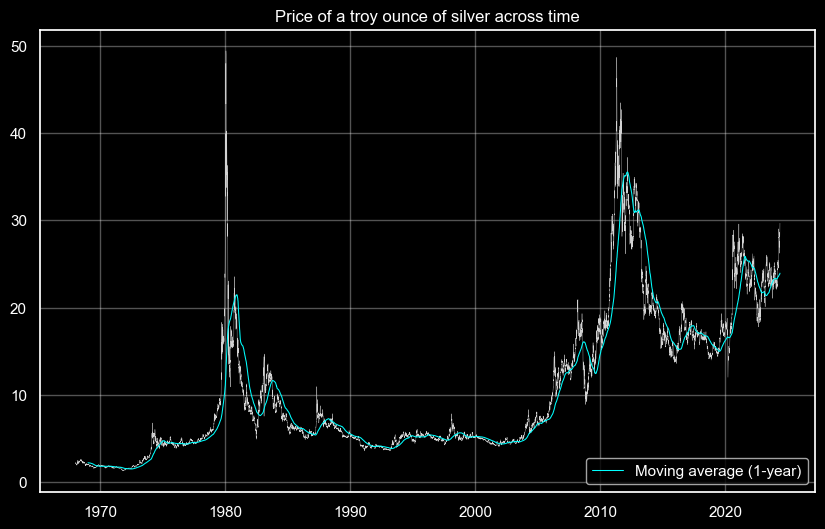

In [8]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_ag, x=df_ag.index, y="price", color="lightgrey", linewidth=0.25)
sns.lineplot(data=df_ag, x=df_ag.index, y="price_1y_ma", label="Moving average (1-year)", color="aqua", linewidth=0.75)

plt.title("Price of a troy ounce of silver across time")
plt.xlabel("")
plt.ylabel("")

save_chart_as_png("1.2_AG_price")

**It's easier to see the early price fluctuations with a logarithmic scale on the y-axis**

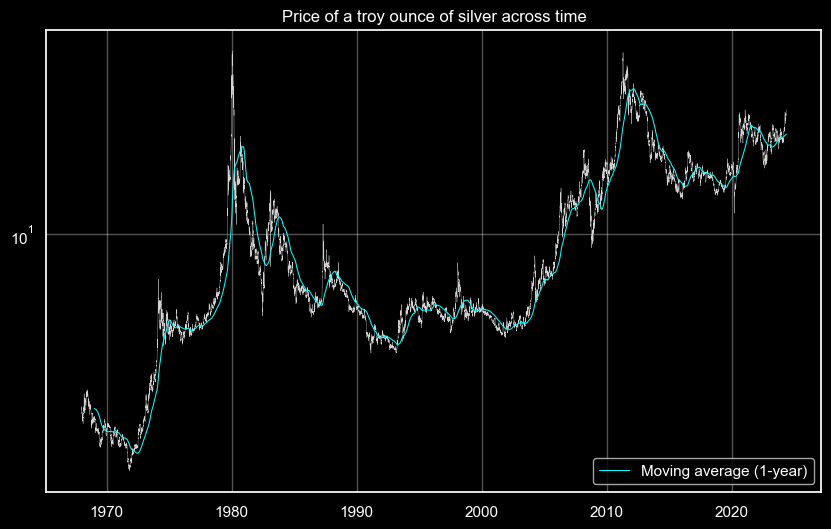

In [9]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_ag, x=df_ag.index, y="price", color="lightgrey", linewidth=0.25)
sns.lineplot(data=df_ag, x=df_ag.index, y="price_1y_ma", label="Moving average (1-year)", color="aqua", linewidth=0.75)

# Compress the y axis to see early price fluctuations
plt.yscale("log")

plt.title("Price of a troy ounce of silver across time")
plt.xlabel("")
plt.ylabel("")

save_chart_as_png("1.2_AG_price_log")

In [10]:
# All-time high
ath_date = df_ag["price"].idxmax()
df_ag.loc[[ath_date]]

,price,price_1y_ma
date,,
1980-01-18,49.45,12.801873


In [11]:
# All-time low
atl_date = df_ag["price"].idxmin()
df_ag.loc[[atl_date]]

,price,price_1y_ma
date,,
1971-11-02,1.272,1.59446


In [12]:
# Peaks
peaks, _ = signal.find_peaks(df_ag["price"], distance=1000)
df_ag.iloc[peaks].nlargest(12, "price").sort_values("date")[["price"]].T

date,1968-06-12,1974-02-26,1980-01-18,1987-04-27,1994-02-04,1998-02-06,2002-05-24,2006-05-12,2011-04-28,2016-08-02,2021-02-01
price,2.576,6.761,49.45,10.925,5.455,7.81,4.855,14.94,48.7,20.71,29.585


In [13]:
# Valleys
valleys, _ = signal.find_peaks(-df_ag["price"], distance=1000)
df_ag.iloc[valleys].nsmallest(12, "price").sort_values("date")[["price"]].T

date,1971-11-02,1976-01-21,1982-06-07,1986-05-20,1991-02-25,1997-07-17,2001-11-21,2005-11-07,2010-02-08,2016-01-28,2020-03-19,2024-03-13
price,1.272,3.83,5.92,4.853,3.548,4.224,4.065,7.485,15.14,13.58,12.005,24.3


In [14]:
# Price appreciation since first entry
first_entry_price = df_ag.iloc[0]["price"]
last_entry_price = df_ag.iloc[-1]["price"]
(last_entry_price - first_entry_price) / first_entry_price

12.658536585365852

**Key takeaways:**
- Silver hit its historic low in 1970, hovering around \$1.3.
- Similar to gold, its value surged swiftly from the early 1970s.
- The pinnacle was reached in 1980, soaring to \$49.5.
- Following this peak, a period of decline ensued until the early 1990s, stabilizing thereafter until the early 2000s.
- Subsequently, there was a consistent ascent until the early 2010s, culminating in a peak of approximately \$48.7 in 2011.
- Despite some fluctuations, there was a general downtrend and stabilization until the onset of the pandemic, after which a renewed ascent began.
- The price has appreciated by approximately 1,270% since its initial point.

### Price change year-over-year

In [15]:
# Get YoY returns
# Get yearly silver price df with first and last prices
df_ag_yearly = df_ag.groupby(df_ag.index.year)["price"].agg(
    first_price="first",
    last_price="last"
)
# Get YoY return
df_ag_yearly["price_change"] = (df_ag_yearly["last_price"] - df_ag_yearly["first_price"]) / df_ag_yearly["first_price"]

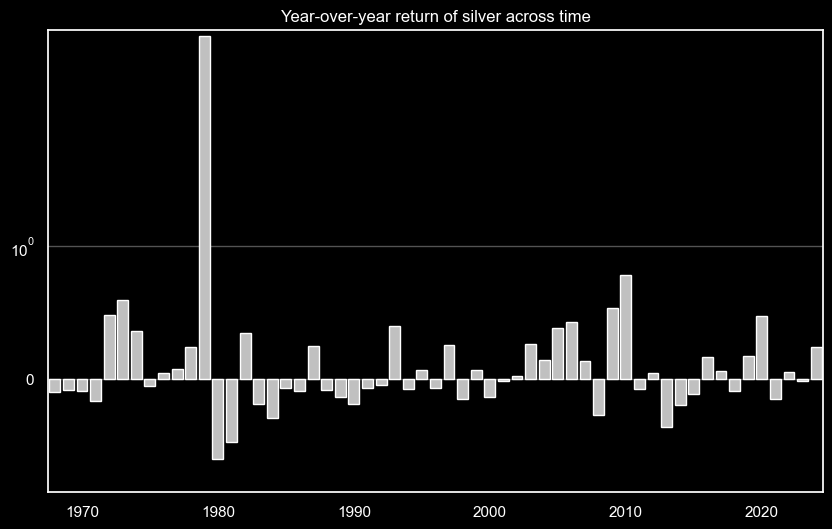

In [16]:
plt.figure(figsize=(10, 6))

sns.barplot(data=df_ag_yearly, x=df_ag_yearly.index, y="price_change", color="silver")

# Compress the y axis to see smaller bars
plt.yscale("symlog")

plt.title("Year-over-year return of silver across time")
plt.xlabel("")
plt.ylabel("")

# Show only beginning of decade
ax = plt.gca()
for index, label in enumerate(ax.get_xticklabels()):
    if index % 10 - 2 != 0:
        label.set_visible(False)

save_chart_as_png("1.2_AG_YoY_return")

In [17]:
# Highest YoY return
df_ag_yearly.loc[[df_ag_yearly["price_change"].idxmax()]]

,first_price,last_price,price_change
date,,,
1979,6.083,32.2,4.293441


In [18]:
# Lowest YoY return
df_ag_yearly.loc[[df_ag_yearly["price_change"].idxmin()]]

,first_price,last_price,price_change
date,,,
1980,39.95,15.5,-0.612015


In [19]:
# Average YoY return
df_ag_yearly["price_change"].mean().round(4)

0.1184

In [20]:
# Average YoY return excluding 1979
df_ag_yearly.loc[df_ag_yearly.index != 1979,"price_change"].mean().round(4)

0.0439

In [21]:
# Median YoY return
df_ag_yearly["price_change"].median().round(4)

-0.0153

In [22]:
# Standard deviation YoY return
df_ag_yearly["price_change"].std().round(4)

0.6233

In [23]:
# Cumulative product YoY return
(1 + df_ag_yearly["price_change"]).cumprod().iloc[-1].round(4) - 1

7.4505

In [24]:
# Get max, min, average, median, standard deviation and cumulative product YoY return per decade
df_ag_yearly["decade"] = (df_ag_yearly.index // 10) * 10
df_ag_yearly.groupby("decade").agg(
    max_yoy_price_change=("price_change", lambda x: x.max().round(4)),
    min_yoy_price_change=("price_change", lambda x: x.min().round(4)),
    avg_yoy_price_change=("price_change", lambda x: x.mean().round(4)),
    median_yoy_price_change=("price_change", lambda x: x.median().round(4)),
    std_yoy_price_change=("price_change", lambda x: x.std().round(4)),
    cumprod_yoy_price_change=("price_change", lambda x: (1 + x).cumprod().iloc[-1].round(4) - 1),
    dod_price_change=("decade", lambda x: (df_ag_yearly.loc[x.index, "last_price"].iloc[-1] - df_ag_yearly.loc[x.index, "first_price"].iloc[0]) / df_ag_yearly.loc[x.index, "first_price"].iloc[0])
).T

decade,1960,1970,1980,1990,2000,2010,2020
max_yoy_price_change,-0.085300,4.293400,0.348300,0.397500,0.533400,0.783900,0.477500
min_yoy_price_change,-0.104000,-0.170600,-0.612000,-0.195200,-0.277300,-0.368300,-0.153500
avg_yoy_price_change,-0.094600,0.576900,-0.138300,0.015500,0.146000,0.034800,0.117800
median_yoy_price_change,-0.094600,0.155500,-0.115700,-0.061100,0.136600,-0.020300,0.046100
std_yoy_price_change,0.013200,1.330400,0.292300,0.186300,0.258100,0.310300,0.246100
cumprod_yoy_price_change,-0.180400,15.794000,-0.873900,0.013500,2.067400,-0.013500,0.588100
dod_price_change,-0.175794,16.888889,-0.869412,0.023033,2.203847,0.050961,0.655788


**Key takeaways:**
- In 1979, silver experienced an astonishing surge, with a remarkable 430% increase.
- However, the following year, it plummeted, marking the lowest return at approximately -61.2%.
- Over the years, silver has shown an average year-over-year return of approximately 11.8%, surpassing gold. Yet, the median return stands at -1.5%.
- When 1979 is ignored, the average YoY drops significantly to about 4.4%.
- Mirroring gold's performance, the 1970s emerged as the standout decade for silver, boasting an average YoY return of around 58%, with a much lower median.
- The 1980s, in contrast, witnessed a downturn, with an average return of approximately -13.8%.
- During the 2000s, the price rebounded with an average return of about 14.6%.
- As we go through the current decade, silver continues to show promise with an average return of around 11.8%. However, the median return hovers around 4.6%.

### Yearly volatility

In [25]:
# Get log returns
df_ag["log_returns"] = np.log(df_ag["price"] / df_ag["price"].shift(1))

In [26]:
# Biggest price changes
df_ag.loc[df_ag["log_returns"].abs().sort_values(ascending=False).head(10).index, ["log_returns"]].T

date,1983-02-05,1983-02-07,1979-09-18,1987-04-28,1980-04-01,1980-03-19,1980-01-02,1980-03-27,2020-03-16,1980-03-17
log_returns,-0.629634,0.596443,0.31181,-0.257479,0.23038,0.218313,0.215662,-0.205489,-0.195856,-0.190964


In [27]:
# Get yearly volatility with the exponentially weighted moving average method
df_ag["volatility_1y"] = df_ag["log_returns"].ewm(span=252).std()

In [28]:
# Change first year values to NaN to avoid having unreliable volatility measures
df_ag.loc[:df_ag.index[251], "volatility_1y"] = np.nan

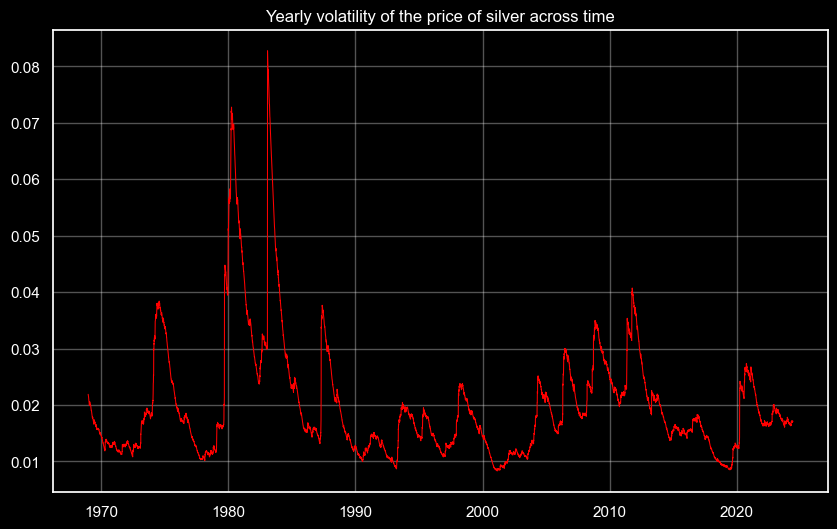

In [29]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_ag,x=df_ag.index,y="volatility_1y", color="red", linewidth=0.75)

plt.title("Yearly volatility of the price of silver across time")
plt.xlabel("")
plt.ylabel("")

save_chart_as_png("1.2_AG_Y_vlt")

In [30]:
# All-time high
ath_date = df_ag["volatility_1y"].idxmax()
df_ag.loc[[ath_date], ["price", "volatility_1y"]]

,price,volatility_1y
date,,
1983-02-07,13.69,0.082771


In [31]:
# All-time low
atl_date = df_ag["volatility_1y"].idxmin()
df_ag.loc[[atl_date], ["price", "volatility_1y"]]

,price,volatility_1y
date,,
2001-02-20,4.498,0.00834


In [32]:
# Top 5 peaks
peaks, _ = signal.find_peaks(df_ag["volatility_1y"], distance=500)
df_ag.iloc[peaks].nlargest(5, "volatility_1y").sort_values("date")[["volatility_1y"]].T

date,1974-08-02,1980-04-10,1983-02-07,1987-05-27,2011-10-06
volatility_1y,0.038413,0.072789,0.082771,0.03767,0.040735


In [33]:
# Top 5 valleys
valleys, _ = signal.find_peaks(-df_ag["volatility_1y"], distance=500)
df_ag.iloc[valleys].nsmallest(5, "volatility_1y").sort_values("date")[["volatility_1y"]].T

date,1978-03-06,1990-08-01,1993-03-29,2001-02-20,2019-06-13
volatility_1y,0.010169,0.009985,0.008684,0.00834,0.008505


In [34]:
# Average 1-year volatility
df_ag["volatility_1y"].mean().round(3)

0.02

In [35]:
# Average 1-year volatility per decade
df_ag_dec = df_ag.groupby((df_ag.index.year // 10) * 10)
df_ag_dec = df_ag_dec["volatility_1y"].mean().round(3).reset_index()
df_ag_dec.columns = ["decade", "average_volatility_1y"]
df_ag_dec.set_index("decade").T

decade,1960,1970,1980,1990,2000,2010,2020
average_volatility_1y,0.017,0.018,0.031,0.015,0.018,0.019,0.019


**Key takeaways:**
- The 1980s witnessed the largest daily price fluctuations.
- Over the years, the average yearly volatility has been 2%.
- The all-time high was in 1983, and the all-time low in 2001.
- Periods of heightened volatility occurred during the mid-70s and early 80s, and also during major economic events such as the Great Recession, EU sovereign debt crisis, and the pandemic.
- Conversely, the market was very stable during the 90s, early 2000s, and late 2010s.

### STL decomposition (trend, seasonality, and residuals)

In [36]:
stl = STL(df_ag["price"], period=252).fit()

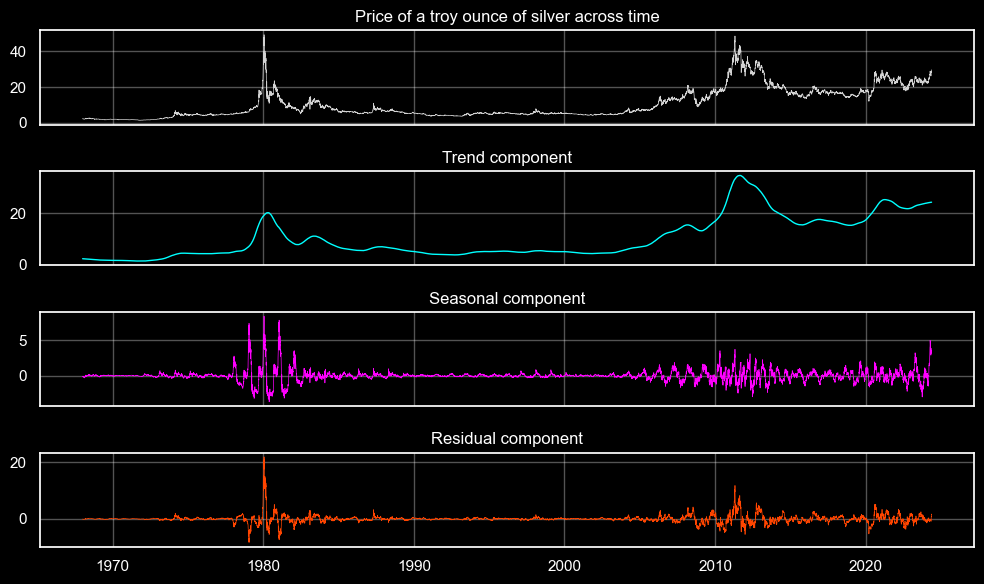

In [37]:
fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

axes[0].plot(df_ag.index, df_ag["price"], label="Original", color="lightgrey", linewidth=0.5)
axes[0].set_title("Price of a troy ounce of silver across time")

axes[1].plot(df_ag.index, stl.trend, label="Trend", color="aqua", linewidth=1)
axes[1].set_title("Trend component")

axes[2].plot(df_ag.index, stl.seasonal, label="Seasonal", color="fuchsia", linewidth=0.5)
axes[2].set_title("Seasonal component")

axes[3].plot(df_ag.index, stl.resid, label="Residual", color="orangered", linewidth=0.5)
axes[3].set_title("Residual component")

plt.tight_layout()

#### Trend analysis

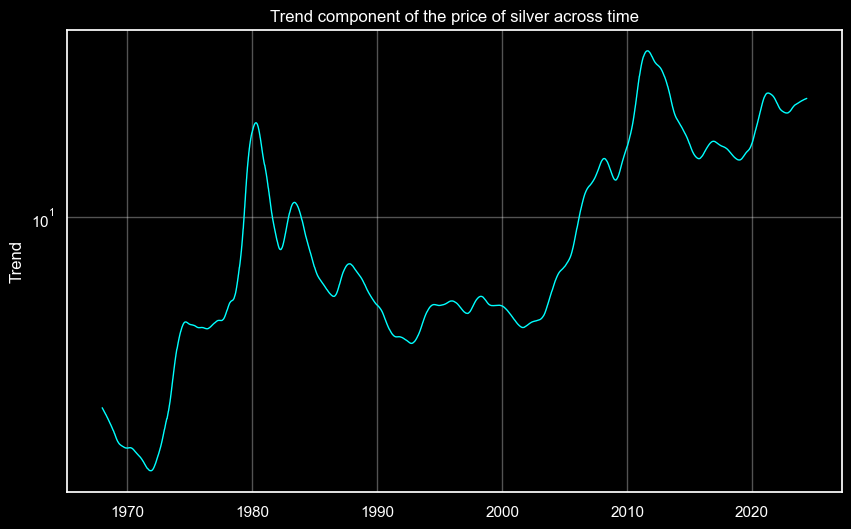

In [38]:
plt.figure(figsize=(10, 6))

plt.plot(stl.trend, color="aqua", linewidth=1)

plt.title("Trend component of the price of silver across time")
plt.xlabel("")
plt.ylabel("Trend")

plt.yscale("log")

save_chart_as_png("1.2_AG_trend")

**Key takeaways:**
- The trend grew significantly throughout the 1970s.
- Following this peak, there was a gradual decline until the 1990s.
- After that, there was a resurgence from the early 2000s until the early 2010s.
- There's 30-year valley spanning from the 1980s to the 2010s.

#### Seasonality analysis

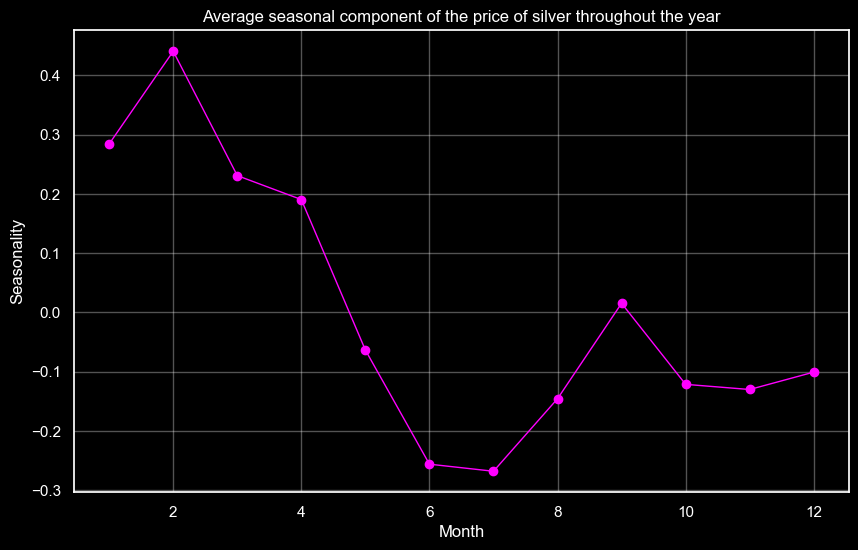

In [39]:
seasonal = stl.seasonal
monthly_avgs = seasonal.groupby(seasonal.index.month).mean()

plt.figure(figsize=(10, 6))

plt.plot(monthly_avgs.index, monthly_avgs.values, marker='o', color="fuchsia", linewidth=1)

plt.title("Average seasonal component of the price of silver throughout the year")
plt.xlabel("Month")
plt.ylabel("Seasonality")

save_chart_as_png("1.2_AG_seasonal")

**Key takeaways:**
- Seasonality has variations across different years.
- Just like gold, based on monthly averages, there's favorable seasons during the first four months of the year, with an additional peak in September.

## Price of silver year-to-date (short-term analysis)

In [40]:
# Get YTD df
df_ag_ytd = df_ag["2024":].copy()

In [41]:
# Get price change
df_ag_ytd["price_change"] = df_ag_ytd["price"].pct_change()

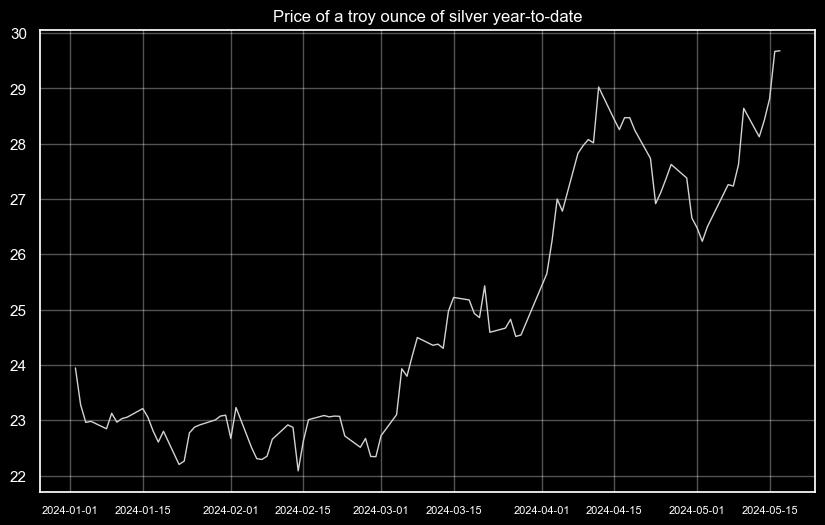

In [42]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_ag_ytd, x=df_ag_ytd.index, y="price", color="lightgrey", linewidth=1)

plt.xticks(fontsize=8)

plt.title("Price of a troy ounce of silver year-to-date")
plt.xlabel("")
plt.ylabel("")

save_chart_as_png("1.2_AG_price_YTD")

In [43]:
# Price change YTD
first_price = df_ag_ytd.iloc[0]["price"]
last_price = df_ag_ytd.iloc[-1]["price"]
(last_price - first_price) / first_price

0.2395072040091877

In [44]:
# When the price quickly began to rise
rise_start = df_ag_ytd.loc[df_ag_ytd["price"].diff() > 0.75].index[0]
df_ag_ytd.loc[[rise_start], ["price", "price_change"]].round(2)

,price,price_change
date,,
2024-03-05,23.93,0.04


In [45]:
# When the price sort of peaked
peak_date = df_ag_ytd[:"2024-05-01"]["price"].idxmax()
df_ag_ytd.loc[[peak_date], ["price", "price_change"]].round(2)

,price,price_change
date,,
2024-04-12,29.02,0.04


In [46]:
# Average daily price change during the rise
df_ag_ytd.loc[rise_start:peak_date]["price_change"].mean().round(5)

0.00866

In [47]:
# Average price before the rise
avg_price_before = df_ag_ytd.loc[:rise_start]["price"].mean().round(0)
avg_price_before

23.0

In [48]:
# Average price after the peak
avg_price_after = df_ag_ytd.loc[peak_date:]["price"].mean().round(0)
avg_price_after

28.0

In [49]:
# Difference between the average prices
((avg_price_after - avg_price_before) / avg_price_before).round(3)

0.217

**Key takeaways:**
- The year-to-date price change stands at approximately 24%.
- Prior to the breakout, the average price lingered around \$23.
- A notable price breakout occurred in early March.
- Post-breakout, the price exhibited an average daily increase of about 0.9%.
- The price peaked around \$29 in mid-April.
- Since reaching its peak, the average price has stabilized around \$28.

### Weekly volatility

In [50]:
# Get weekly volatility with the exponentially weighted moving average method
df_ag_ytd["volatility_1w"] = df_ag_ytd["log_returns"].ewm(span=5).std()

In [51]:
# Change first week values to NaN to avoid having unreliable volatility measures
df_ag_ytd.loc[:df_ag_ytd.index[4], "volatility_1w"] = np.nan

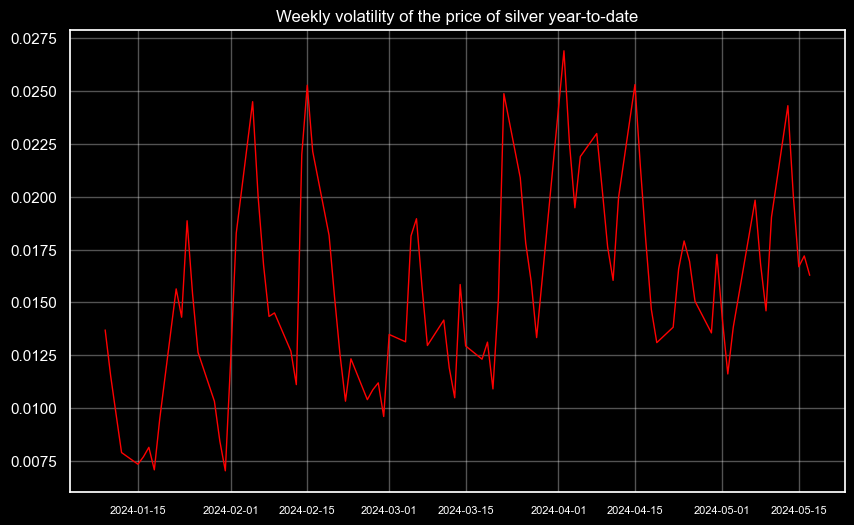

In [52]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_ag_ytd, x=df_ag_ytd.index, y="volatility_1w", color="red", linewidth=1)

plt.xticks(fontsize=8)

plt.title("Weekly volatility of the price of silver year-to-date")
plt.xlabel("")
plt.ylabel("")

save_chart_as_png("1.2_AG_W_vlt_YTD")

In [53]:
# Average volatility
df_ag_ytd["volatility_1w"].mean().round(4)

0.0155

**Key takeaways:**
- Average weekly volatility has been gradually increasing over time.
- Unlike gold, silver has not shown any clear breakout trends.